# 🧪 Практическая работа: Обобщающая способность модели (Food-101 mini)

В этой работе мы разберём, как модель учится обобщать на новых данных,  
и шаг за шагом проведём серию экспериментов на мини-версии датасета **Food-101**.

---

## 🔹 Данные
- Используем датасет **Food-101** (15 классов, уменьшенная выборка).

---

## 🔹 Модель
- Берём **предобученную ResNet-18** из `torchvision`. 

---

## 🔹 Эксперименты
1. **Бейзлайн** — без аугментаций.  
2. **Слабые аугментации** — crop, flip, цветовые искажения.  
3. **Сильные аугментации + регуляризация** — RandAugment, MixUp, Dropout, Label Smoothing.  
4. Сравниваем результаты всех моделей по метрикам и визуализациям.  

---

In [1]:
# ============================================================
# Подготовка окружения: импорты, устройство, конфиг.
# Этот блок ничего не скачивает и не обучает — только настраивает.
# ============================================================
# --- стандартные библиотеки ---
import os, math, random, time
from dataclasses import dataclass
from typing import List, Tuple, Dict
import pandas as pd # для таблиц
import matplotlib.pyplot as plt  # для графиков
import numpy as np

# --- PyTorch ядро ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Hugging Face Datasets: для загрузки готовых датасетов (изображения, тексты и др.)
from datasets import load_dataset

# TorchVision: стандартные преобразования изображений (resize, crop, normalize и т.д.)
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

# -----------------------------
# Функция для воспроизводимости
# -----------------------------
# ========== ВОСПРОИЗВОДИМОСТЬ ==========
def set_seed(seed: int = 42) -> None:
    """Фиксирует ГСЧ для повторяемых результатов (Python/NumPy/PyTorch)."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(42)

# -----------------------------
# Определение устройства (CPU/GPU)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if torch.cuda.is_available():
    # Детерминизм на CUDA (чуть медленнее, но стабильнее)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # При необходимости:
    # torch.use_deterministic_algorithms(True)  


Device: cuda


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})
Классов: 101
Первые 10 классов: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']
Train size: 75,750 | Test size (официальный): 25,250


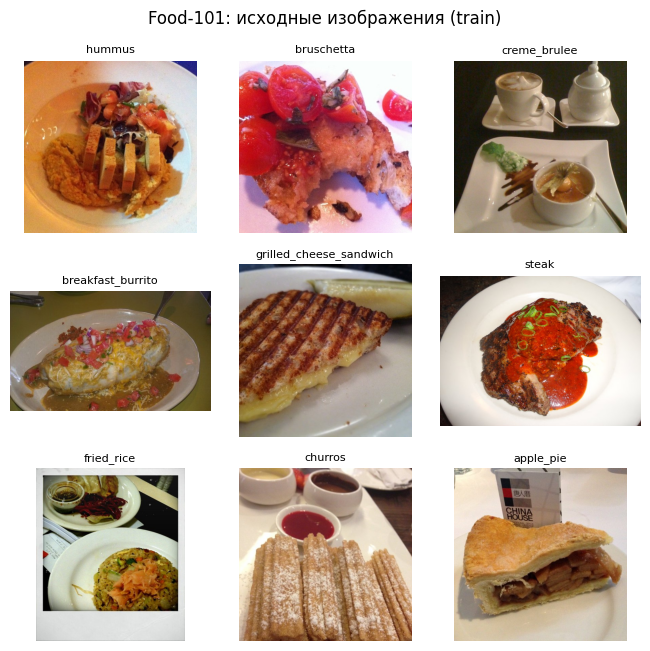

In [2]:
# ===== загрузка Food-101 + check =====
from collections import Counter
from datasets import DatasetDict

DATA_CACHE_DIR = "./data_cache"  # можно поменять на свой путь
ds = load_dataset("food101", cache_dir=DATA_CACHE_DIR)
print(ds)  # какие сплиты и сколько объектов

# В HF: 'validation' = официальный тест Food-101
train_hf = ds["train"]
test_hf  = ds["validation"]

# Список классов и их число
class_names = train_hf.features["label"].names
num_classes = len(class_names)
print(f"Классов: {num_classes}")
print("Первые 10 классов:", class_names[:10])

# Быстрые суммарные размеры (без тяжелых проходов)
print(f"Train size: {len(train_hf):,} | Test size (официальный): {len(test_hf):,}")

# --- универсальная функция для вывода изображений ---
def show_images(split, idxs=None, rows=3, cols=3, seed=42, title="Примеры изображений"):
    set_seed(seed)
    if idxs is None:
        idxs = random.sample(range(len(split)), k=min(rows * cols, len(split)))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    fig.suptitle(title, y=0.98, fontsize=12)
    for ax, i in zip(axs.ravel(), idxs):
        ex = split[int(i)]
        img, label = ex["image"], class_names[int(ex["label"])]
        ax.imshow(img)
        ax.set_title(label, fontsize=8)
        ax.axis("off")
    for ax in axs.ravel()[len(idxs):]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# фиксируем 9 случайных индексов, чтобы потом использовать те же
show_images(train_hf, title="Food-101: исходные изображения (train)")

Выбрали 15 классов:
 ['baby_back_ribs', 'breakfast_burrito', 'bruschetta', 'ceviche', 'deviled_eggs', 'dumplings', 'french_toast', 'fried_rice', 'hot_dog', 'macarons', 'nachos', 'panna_cotta', 'poutine', 'prime_rib', 'waffles']
TRAIN (MINI-15) (N=9000)


class_id              class  count
0          1     baby_back_ribs    600
1          9  breakfast_burrito    600
2         10         bruschetta    600
3         15            ceviche    600
4         30       deviled_eggs    600
5         32          dumplings    600
6         42       french_toast    600
7         44         fried_rice    600
8         55            hot_dog    600
9         63           macarons    600
10        66             nachos    600
11        73        panna_cotta    600
12        78            poutine    600
13        79          prime_rib    600
14       100            waffles    600

VAL   (MINI-15) (N=2250)


class_id              class  count
0          1     baby_back_ribs    150
1          9  breakfast_burrito    150
2         10         bruschetta    150
3         15            ceviche    150
4         30       deviled_eggs    150
5         32          dumplings    150
6         42       french_toast    150
7         44         fried_rice    150
8         55            hot_dog    150
9         63           macarons    150
10        66             nachos    150
11        73        panna_cotta    150
12        78            poutine    150
13        79          prime_rib    150
14       100            waffles    150

TEST  (MINI-15) (N=3750)


class_id              class  count
0          1     baby_back_ribs    250
1          9  breakfast_burrito    250
2         10         bruschetta    250
3         15            ceviche    250
4         30       deviled_eggs    250
5         32          dumplings    250
6         42       french_toast    250
7         44         fried_rice    250
8         55            hot_dog    250
9         63           macarons    250
10        66             nachos    250
11        73        panna_cotta    250
12        78            poutine    250
13        79          prime_rib    250
14       100            waffles    250

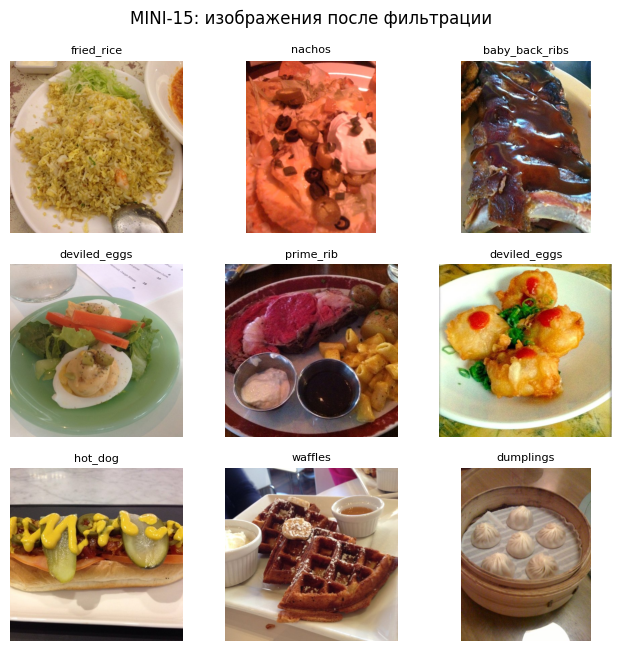

In [3]:
# =============== MINI-15 (train=600, val=150, test=250 на класс) ===============
set_seed(42)  # воспроизводимость выборки

from collections import defaultdict, Counter
from datasets import DatasetDict

K_CLASSES = 15
TRAIN_PER_CLASS = 600
VAL_PER_CLASS   = 150
TEST_PER_CLASS  = 250

# 1) выбираем K классов
all_cls_ids = np.arange(len(class_names))
random.shuffle(all_cls_ids)
chosen_cls = np.sort(all_cls_ids[:K_CLASSES])
chosen_names = [class_names[i] for i in chosen_cls]
print(f"Выбрали {K_CLASSES} классов:\n", chosen_names)

# 2) собираем индексы по классам
by_lbl_train = defaultdict(list)
for i, y in enumerate(train_hf["label"]):
    if y in chosen_cls:
        by_lbl_train[int(y)].append(i)

by_lbl_test = defaultdict(list)
for i, y in enumerate(test_hf["label"]):
    if y in chosen_cls:
        by_lbl_test[int(y)].append(i)

# 3) формируем train/val/test
train_idx_total, val_idx_total, test_idx_total = [], [], []
for c in chosen_cls:
    tr_ids = by_lbl_train[int(c)]
    random.shuffle(tr_ids)
    need_val   = min(VAL_PER_CLASS, len(tr_ids))
    need_train = min(TRAIN_PER_CLASS, max(0, len(tr_ids) - need_val))

    val_idx_c   = tr_ids[:need_val]
    train_idx_c = tr_ids[need_val:need_val + need_train]

    te_ids = by_lbl_test[int(c)]
    random.shuffle(te_ids)
    test_idx_c = te_ids[:min(TEST_PER_CLASS, len(te_ids))]

    val_idx_total.extend(val_idx_c)
    train_idx_total.extend(train_idx_c)
    test_idx_total.extend(test_idx_c)

# 4) собираем HF-сплиты
train_small = train_hf.select(train_idx_total)
val_small   = train_hf.select(val_idx_total)
test_small  = test_hf.select(test_idx_total)

food101_small = DatasetDict({
    "train": train_small,
    "val":   val_small,
    "test":  test_small
})

# 5) быстрая сводка
def balance_table(split, title):
    cnt = Counter(split["label"])
    df = pd.DataFrame({
        "class_id": chosen_cls,
        "class": [class_names[i] for i in chosen_cls],
        "count": [cnt.get(int(c), 0) for c in chosen_cls],
    }).sort_values("class").reset_index(drop=True)
    print(f"{title} (N={len(split)})"); display(df)
    return df

bt_train = balance_table(food101_small["train"], "TRAIN (MINI-15)")
bt_val   = balance_table(food101_small["val"],   "VAL   (MINI-15)")
bt_test  = balance_table(food101_small["test"],  "TEST  (MINI-15)")

# 6) визуальная проверка
SAMPLE_IDX = random.sample(range(len(food101_small["train"])), 9)
show_images(food101_small["train"], SAMPLE_IDX, title="MINI-15: изображения после фильтрации")

In [4]:
# =============== Ремаппер меток под MINI-15 ===============
set_seed(42)

# строим отображение: старый id -> новый [0..NUM_CLASSES-1]
LABEL2NEW = {int(old): i for i, old in enumerate(chosen_cls)}
NEW2LABEL = {v: k for k, v in LABEL2NEW.items()}

NUM_CLASSES = len(chosen_cls)
print("NUM_CLASSES =", NUM_CLASSES)
print("Пример маппинга:", list(LABEL2NEW.items())[:5])

NUM_CLASSES = 15
Пример маппинга: [(1, 0), (9, 1), (10, 2), (15, 3), (30, 4)]


✅ DataLoader'ы готовы: train=9000, val=2250, test=3750, batch=64
Формы батча: torch.Size([64, 3, 224, 224]) torch.Size([64])


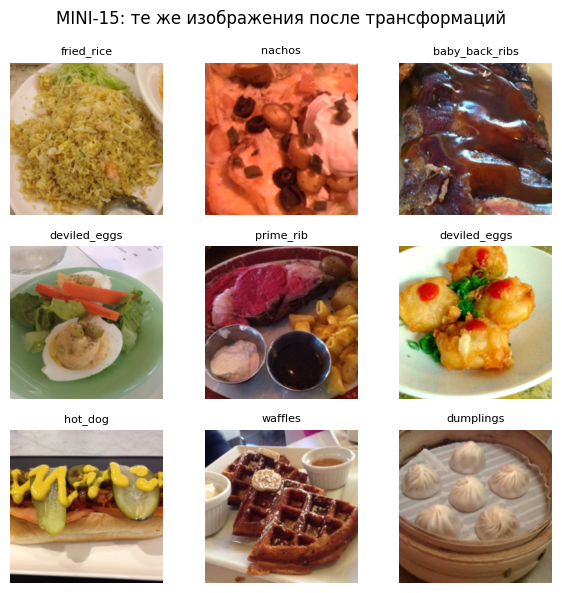

In [5]:
# ===============  трансформации (без аугм) + DataLoader’ы ===============
set_seed(42)

# --- базовые параметры трансформаций ---
IMG_SIZE = 224
MEAN = (0.485, 0.456, 0.406)
STD  = (0.229, 0.224, 0.225)

# --- трансформации (бейзлайн, без аугментаций) ---
baseline_tf = T.Compose([
    T.Resize(256, interpolation=InterpolationMode.BILINEAR),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

# --- простая обёртка под HF split ---
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_split, transform, label_map):
        self.data = hf_split
        self.tf = transform
        self.label_map = label_map
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        x = self.tf(ex["image"])
        y_old = int(ex["label"])
        y = self.label_map[y_old] 
        return x, y

train_ds = HFDataset(food101_small["train"], baseline_tf, LABEL2NEW)
val_ds   = HFDataset(food101_small["val"],   baseline_tf, LABEL2NEW)
test_ds  = HFDataset(food101_small["test"],  baseline_tf, LABEL2NEW)

# --- DataLoader'ы ---
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoader'ы готовы: train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}, batch={BATCH_SIZE}")

# --- проверка одного батча ---
xb, yb = next(iter(train_loader))
print('Формы батча:', xb.shape, yb.shape)

# --- визуализация именно тех же картинок, что и в Блоке 2 ---
mean = torch.tensor(MEAN)[:, None, None]
std  = torch.tensor(STD)[:, None, None]
fig, axs = plt.subplots(3, 3, figsize=(6,6))
fig.suptitle("MINI-15: те же изображения после трансформаций", y=0.98, fontsize=12)

for ax, idx in zip(axs.ravel(), SAMPLE_IDX):
    ex = food101_small["train"][idx]
    img_after = baseline_tf(ex["image"])
    img_show = (img_after * std + mean).permute(1,2,0).numpy().clip(0,1)
    ax.imshow(img_show)
    ax.set_title(class_names[int(ex["label"])], fontsize=8)
    ax.axis("off")

plt.tight_layout(); plt.show()


### Препроцессинг под ResNet и DataLoader’ы

Дальше в качестве базовой модели мы будем использовать **ResNet-18**, предобученный на датасете **ImageNet**.  
Это классическая архитектура, которая служит «стандартом де-факто» для визуальных экспериментов:  
она лёгкая, стабильная, и хорошо показывает общие принципы обобщения модели.

#### 🔹 Почему важно подать данные в том же формате, что и у ImageNet

Предобученные модели в `torchvision` (ResNet, VGG, EfficientNet и др.) обучались на **ImageNet-1k**,  
и ожидают входные изображения в строго определённом формате:

| Параметр | Значение | Назначение |
|-----------|-----------|------------|
| Размер входа | **224×224 px** | фиксированный вход для свёрточной архитектуры |
| Диапазон пикселей | `[0, 1]` после `ToTensor()` | нормализованный масштаб значений |
| Средние значения каналов | **mean = (0.485, 0.456, 0.406)** | средние значения RGB по всему ImageNet |
| Стандартные отклонения | **std = (0.229, 0.224, 0.225)** | разброс значений RGB по всему ImageNet |

Модель была обучена на данных, предварительно стандартизованных по этим статистикам,  
поэтому при инференсе и дообучении нужно использовать **точно такие же** значения.  
Если этого не сделать — распределение входных признаков изменится, и веса, рассчитанные на центрированные данные,  
начнут давать смещения: метрики резко ухудшаются.

#### 🔹 Наш препроцессинг под ResNet

Мы используем базовый пайплайн:
Resize(256) → CenterCrop(224) → ToTensor() → Normalize(mean, std)

- **Resize + CenterCrop** — подгоняет размер и обрезает центр кадра,  
  как делалось при обучении ResNet на ImageNet.  
- **ToTensor** — переводит из PIL-изображения в формат PyTorch `[C, H, W]`, диапазон `[0, 1]`.  
- **Normalize** — приводит данные к тем же статистикам (mean/std), что использовались при предобучении.
  

In [6]:
# =============== Инициализация модели ResNet-18 (бейзлайн) ===============
set_seed(42)

from torchvision import models

NUM_CLASSES = 15  # наша mini-версия Food-101
USE_PRETRAINED = True

# 1) Загружаем предобученный ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if USE_PRETRAINED else None)

# 2) Замораживаем backbone (все сверточные блоки)
for name, param in model.named_parameters():
    param.requires_grad = False

# 3) Заменяем "голову" (fc) под нашу задачу
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# 4) Переносим на GPU
model = model.to(device)

# 5) Короткий отчёт
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ ResNet-18 загружен: всего параметров = {total_params/1e6:.2f}M, "
      f"обучаемых = {trainable_params/1e6:.2f}M")

# 6) Проверяем, что голова действительно новая
print(model.fc)

# 7) Тестовый прогон одного батча
xb, yb = next(iter(train_loader))
xb = xb.to(device)
with torch.no_grad():
    out = model(xb)
print("Выход модели:", out.shape)  # [batch, NUM_CLASSES]


✅ ResNet-18 загружен: всего параметров = 11.18M, обучаемых = 0.01M
Linear(in_features=512, out_features=15, bias=True)
Выход модели: torch.Size([64, 15])


### Заморозка слоев и что такое Transfer Learning

Мы используем **ResNet-18**, уже обученный на большом датасете **ImageNet**  
(1,2 млн изображений, 1000 классов).  
Эта модель уже умеет находить общие визуальные закономерности:  
границы, текстуры, формы и простые объекты.  

#### 🔹 Идея Transfer Learning
Вместо того чтобы обучать сеть с нуля, мы **переносим знания** из одной задачи в другую:
1. Берём предобученную модель — это наш «донор» признаков.  
2. **Замораживаем скелет модели(backbone)** (все свёрточные слои):  
   не обновляем их веса, чтобы не потерять универсальные паттерны.  
3. **Заменяем только «голову» (fc-слой)** под нужное число классов — в нашем случае 15.  
4. Обучаем только эту голову, чтобы адаптировать признаки под новую задачу.

#### 🔹 Зачем это нужно
- Экономим вычислительные ресурсы — обучаем лишь ~0.01 M параметров вместо 11 M.  
- Получаем высокое качество даже при маленьком датасете.  
- Backbone уже умеет «обобщать» — переносит визуальные закономерности с ImageNet на наш Food-101.  

#### 🔹 Почему обучаем именно FC-слой
Последний слой (**Fully Connected**, или просто `fc`)  
— это классификатор, который принимает вектор признаков из backbone  
(например, 512 признаков у ResNet-18)  
и преобразует его в логиты размерности `[количество_классов]`.  

Обучаем именно этот слой, потому что:
- он отвечает за **привязку универсальных признаков к новым классам** (нашим 15 категориям еды);
- его обучение не разрушает знания, уже заложенные в backbone;

In [8]:
from tqdm.auto import tqdm
import torch
import os

set_seed(42)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

EPOCHS = 10
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# ---- настройки чекпоинта ----
best_val_loss = float("inf")
patience = 3
no_improve_epochs = 0
checkpoint_path = "best_model.pt"  # сохранится в корень (текущая рабочая директория)

def accuracy_from_logits(logits, targets):
    preds = logits.argmax(1)
    return (preds == targets).float().mean().item()

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model.train()
    train_loss = train_acc = 0.0
    n_train = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0)
        n_train += bs
        train_loss += loss.item() * bs
        train_acc  += accuracy_from_logits(logits, yb) * bs

    train_loss /= n_train
    train_acc  /= n_train

    # ---- VAL ----
    model.eval()
    val_loss = val_acc = 0.0
    n_val = 0
    for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with torch.no_grad():
            logits = model(xb)
            loss = criterion(logits, yb)
        bs = yb.size(0)
        n_val += bs
        val_loss += loss.item() * bs
        val_acc  += accuracy_from_logits(logits, yb) * bs

    val_loss /= n_val
    val_acc  /= n_val

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} val_loss={val_loss:.4f} | "
          f"train_acc={train_acc*100:.1f}% val_acc={val_acc*100:.1f}%")

    # ---- сохранение лучшего чекпоинта ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
        }, checkpoint_path)
        print(f"💾 Новый лучший чекпоинт сохранён (epoch {epoch})")
    else:
        no_improve_epochs += 1
        print(f"⚠️ Нет улучшения {no_improve_epochs} эпох подряд")

    # ---- early stopping ----
    if no_improve_epochs >= patience:
        print("⛔ Early stopping — улучшений нет, обучение прервано.")
        break

print("✅ Обучение завершено.")
print(f"Лучший чекпоинт сохранён в: {os.path.abspath(checkpoint_path)}")


Epoch 1/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/10 | train_loss=1.7090 val_loss=1.2103 | train_acc=52.5% val_acc=65.2%
💾 Новый лучший чекпоинт сохранён (epoch 1)


Epoch 2/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/10 | train_loss=1.0627 val_loss=0.9946 | train_acc=70.8% val_acc=69.4%
💾 Новый лучший чекпоинт сохранён (epoch 2)


Epoch 3/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/10 | train_loss=0.9169 val_loss=0.9044 | train_acc=73.6% val_acc=72.2%
💾 Новый лучший чекпоинт сохранён (epoch 3)


Epoch 4/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=0.8460 val_loss=0.8613 | train_acc=74.8% val_acc=73.7%
💾 Новый лучший чекпоинт сохранён (epoch 4)


Epoch 5/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/10 | train_loss=0.7991 val_loss=0.8374 | train_acc=75.6% val_acc=73.5%
💾 Новый лучший чекпоинт сохранён (epoch 5)


Epoch 6/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/10 | train_loss=0.7605 val_loss=0.8239 | train_acc=77.1% val_acc=74.3%
💾 Новый лучший чекпоинт сохранён (epoch 6)


Epoch 7/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/10 | train_loss=0.7306 val_loss=0.8154 | train_acc=77.7% val_acc=73.4%
💾 Новый лучший чекпоинт сохранён (epoch 7)


Epoch 8/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/10 | train_loss=0.7150 val_loss=0.8211 | train_acc=77.9% val_acc=74.0%
⚠️ Нет улучшения 1 эпох подряд


Epoch 9/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 9/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/10 | train_loss=0.6968 val_loss=0.8063 | train_acc=78.8% val_acc=75.4%
💾 Новый лучший чекпоинт сохранён (epoch 9)


Epoch 10/10 [train]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 10/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.6784 val_loss=0.8020 | train_acc=79.0% val_acc=75.3%
💾 Новый лучший чекпоинт сохранён (epoch 10)
✅ Обучение завершено.
Лучший чекпоинт сохранён в: C:\Prgrm\Intro_in_ML\practices\practice_5_Generalization\best_model.pt


In [9]:
from sklearn.metrics import accuracy_score, f1_score

set_seed(42)

@torch.no_grad()
def evaluate(model, dataloader):
    """Вычисление accuracy и macro-F1 на заданном split."""
    model.eval()
    all_preds, all_labels = [], []
    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return acc, f1

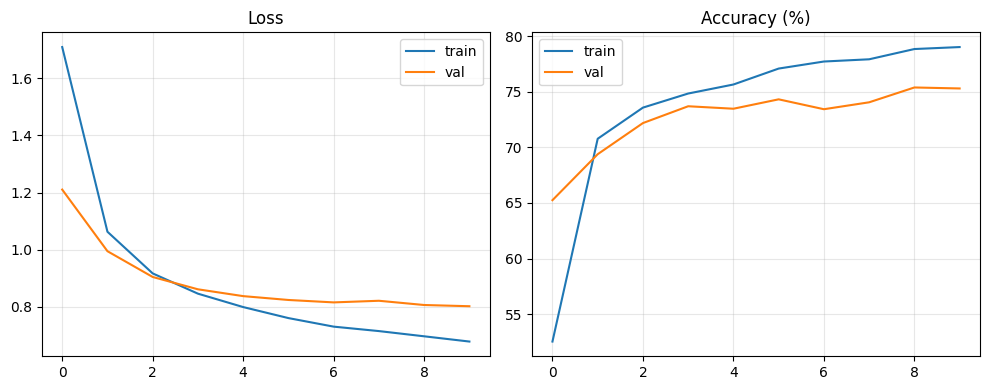

[VAL]  Acc=75.29% | Macro-F1=0.753
[TEST] Acc=79.04% | Macro-F1=0.791


In [10]:
# ---- ГРАФИКИ ----
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(history["train_loss"], label="train")
axs[0].plot(history["val_loss"],   label="val")
axs[0].set_title("Loss"); axs[0].legend(); axs[0].grid(True, alpha=0.3)

axs[1].plot(np.array(history["train_acc"])*100, label="train")
axs[1].plot(np.array(history["val_acc"])*100,   label="val")
axs[1].set_title("Accuracy (%)"); axs[1].legend(); axs[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ---- Итоговые метрики: VAL и TEST (Accuracy, Macro-F1) ----
val_acc, val_f1 = evaluate(model, val_loader)
test_acc, test_f1 = evaluate(model, test_loader)
print(f"[VAL]  Acc={val_acc*100:.2f}% | Macro-F1={val_f1:.3f}")
print(f"[TEST] Acc={test_acc*100:.2f}% | Macro-F1={test_f1:.3f}")

In [14]:
import os, torch

checkpoint_path = "best_model.pt"
assert os.path.exists(checkpoint_path), f"Чекпоинт не найден: {checkpoint_path}"
ckpt = torch.load(checkpoint_path, map_location=device)

# Достаём state_dict из разных вариантов сохранения
if "model_state_dict" in ckpt:
    state = ckpt["model_state_dict"]
elif "state_dict" in ckpt:  # иногда так сохраняют (e.g. Lightning)
    state = ckpt["state_dict"]
else:
    # возможно, сохранён чистый state_dict без обёртки
    state = ckpt

# (необязательно) Проверка метаданных, если сохранял их
if "num_classes" in ckpt:
    assert ckpt["num_classes"] == NUM_CLASSES, \
        f"NUM_CLASSES в ckpt={ckpt['num_classes']} != текущему={NUM_CLASSES}"
if "chosen_cls" in ckpt:
    assert list(ckpt["chosen_cls"]) == list(map(int, chosen_cls)), \
        "Порядок chosen_cls отличается от того, с которым обучалась модель"

# Загружаем веса
model.load_state_dict(state, strict=True)
model = model.to(device).eval()
print(f"✅ Загружен чекпоинт: {checkpoint_path}")


✅ Загружен чекпоинт: best_model.pt


In [17]:
# ===== Блок 0. Импорты и подготовка =====
import os, numpy as np, pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report

sns.set_context("notebook")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Eval [test]", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

print(f"Samples: {len(y_true)}")


Eval [test]:   0%|          | 0/59 [00:00<?, ?it/s]

Samples: 3750


In [35]:
# ===== Отчёт и матрица ошибок =====
class_names_small = [class_names[i] for i in chosen_cls]

# Табличный отчёт (dict → DataFrame)
report = classification_report(
    y_true, y_pred,
    target_names=class_names_small,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()

class_rows = [c for c in report_df.index if c not in ["accuracy", "macro avg", "weighted avg"]]
class_metrics = report_df.loc[class_rows]

summary_metrics = report_df.loc[["accuracy", "macro avg", "weighted avg"]]

# --- Отображаем ---
print("📊 Метрики по классам:")
display(class_metrics)

print("\n📈 Сводные метрики:")
display(summary_metrics)


📊 Метрики по классам:


precision  recall  f1-score  support
baby_back_ribs      0.782427   0.748  0.764826    250.0
breakfast_burrito   0.713147   0.716  0.714571    250.0
bruschetta          0.761905   0.576  0.656036    250.0
ceviche             0.608997   0.704  0.653061    250.0
deviled_eggs        0.785978   0.852  0.817658    250.0
dumplings           0.873134   0.936  0.903475    250.0
french_toast        0.704225   0.800  0.749064    250.0
fried_rice          0.868313   0.844  0.855984    250.0
hot_dog             0.905579   0.844  0.873706    250.0
macarons            0.978723   0.920  0.948454    250.0
nachos              0.651568   0.748  0.696462    250.0
panna_cotta         0.870690   0.808  0.838174    250.0
poutine             0.868996   0.796  0.830898    250.0
prime_rib           0.803347   0.768  0.785276    250.0
waffles             0.762452   0.796  0.778865    250.0


📈 Сводные метрики:


precision  recall  f1-score    support
accuracy       0.790400  0.7904  0.790400     0.7904
macro avg      0.795965  0.7904  0.791101  3750.0000
weighted avg   0.795965  0.7904  0.791101  3750.0000

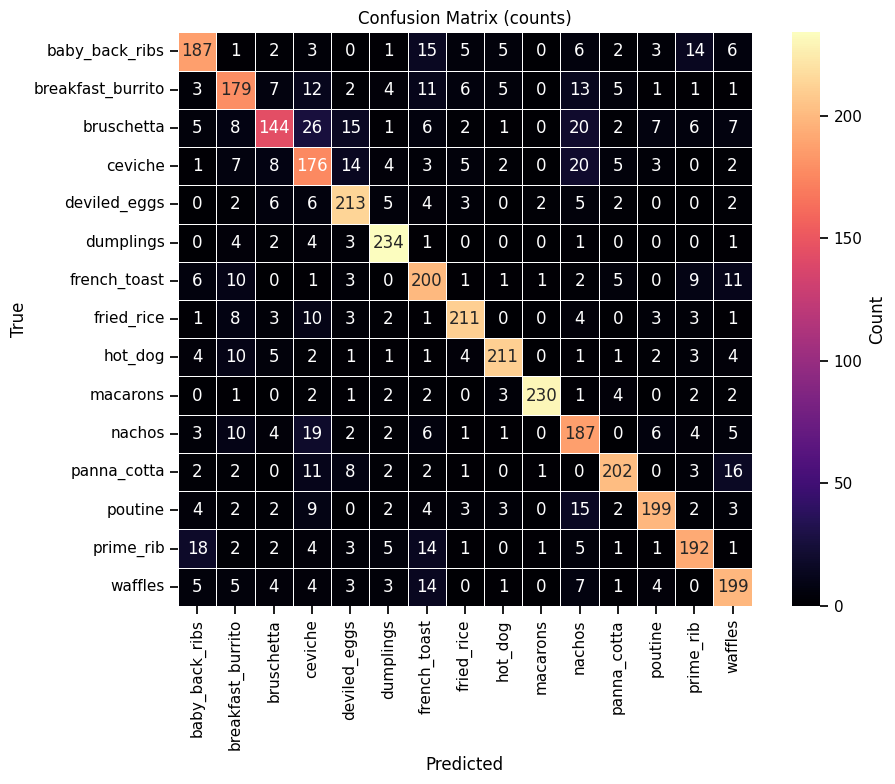

In [36]:
# Матрица ошибок
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, annot=True, fmt="d",
    cmap="magma",
    linewidths=0.5, linecolor="white",
    square=True,
    cbar_kws={"label": "Count"},
    xticklabels=class_names_small,
    yticklabels=class_names_small,
    ax=ax
)

ax.set_title("Confusion Matrix (counts)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


In [37]:
# ===== Блок 6. Топ-пары путаниц =====
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            pairs.append((cm[i, j], i, j))

pairs.sort(reverse=True, key=lambda t: t[0])

top_k = 15
rows = []
for cnt, i, j in pairs[:top_k]:
    rows.append({
        "true_class": class_names_small[i],
        "pred_class": class_names_small[j],
        "count": int(cnt),
        "share_in_true_class_%": float(cm_norm[i, j] * 100.0),
    })
top_confusions_df = pd.DataFrame(rows)
top_confusions_df


true_class      pred_class  count  share_in_true_class_%
0          bruschetta         ceviche     26                   10.4
1          bruschetta          nachos     20                    8.0
2             ceviche          nachos     20                    8.0
3              nachos         ceviche     19                    7.6
4           prime_rib  baby_back_ribs     18                    7.2
5         panna_cotta         waffles     16                    6.4
6      baby_back_ribs    french_toast     15                    6.0
7          bruschetta    deviled_eggs     15                    6.0
8             poutine          nachos     15                    6.0
9      baby_back_ribs       prime_rib     14                    5.6
10            ceviche    deviled_eggs     14                    5.6
11          prime_rib    french_toast     14                    5.6
12            waffles    french_toast     14                    5.6
13  breakfast_burrito          nachos     13                    5.2
14  breakfast_burrito         ceviche     12                    4.8

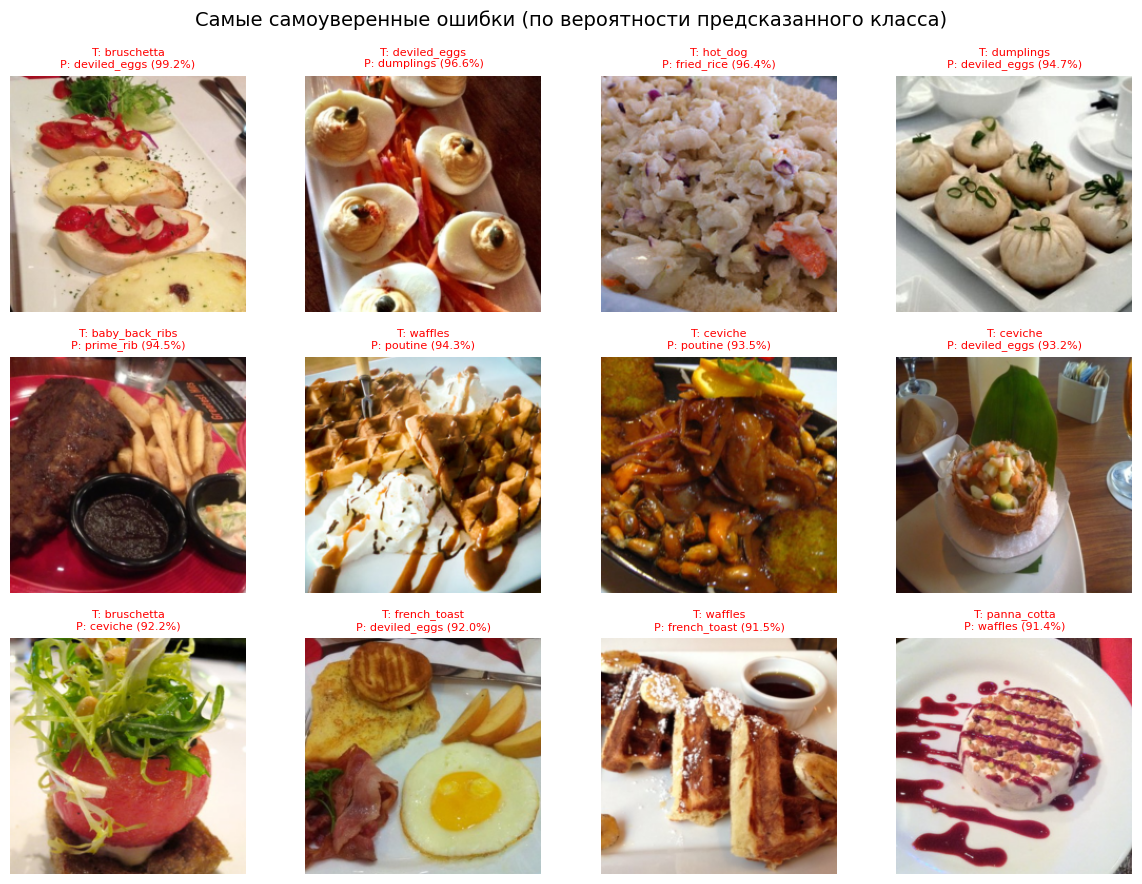

In [38]:
TOP_K = min(12, len(wrong_samples))
# сортируем по убыванию conf (уверенности в неверном ответе)
wrong_sorted = sorted(wrong_samples, key=lambda x: x[3], reverse=True)[:TOP_K]

mean = torch.tensor(MEAN)[:, None, None]
std  = torch.tensor(STD)[:, None, None]

rows = int(np.ceil(TOP_K / 4))
fig, axs = plt.subplots(rows, 4, figsize=(12, 3*rows))
axs = np.array(axs).ravel()

for ax, (img_t, true_y, pred_y, conf) in zip(axs, wrong_sorted):
    img_show = (img_t * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
    ax.imshow(img_show)
    ax.set_title(f"T: {class_names_small[true_y]}\nP: {class_names_small[pred_y]} ({conf*100:.1f}%)",
                 fontsize=8, color="red")
    ax.axis("off")

for ax in axs[len(wrong_sorted):]:
    ax.remove()

plt.suptitle("Самые самоуверенные ошибки (по вероятности предсказанного класса)", y=0.98, fontsize=14)
plt.tight_layout(); plt.show()


Частейшая путаница: bruschetta → ceviche | 26


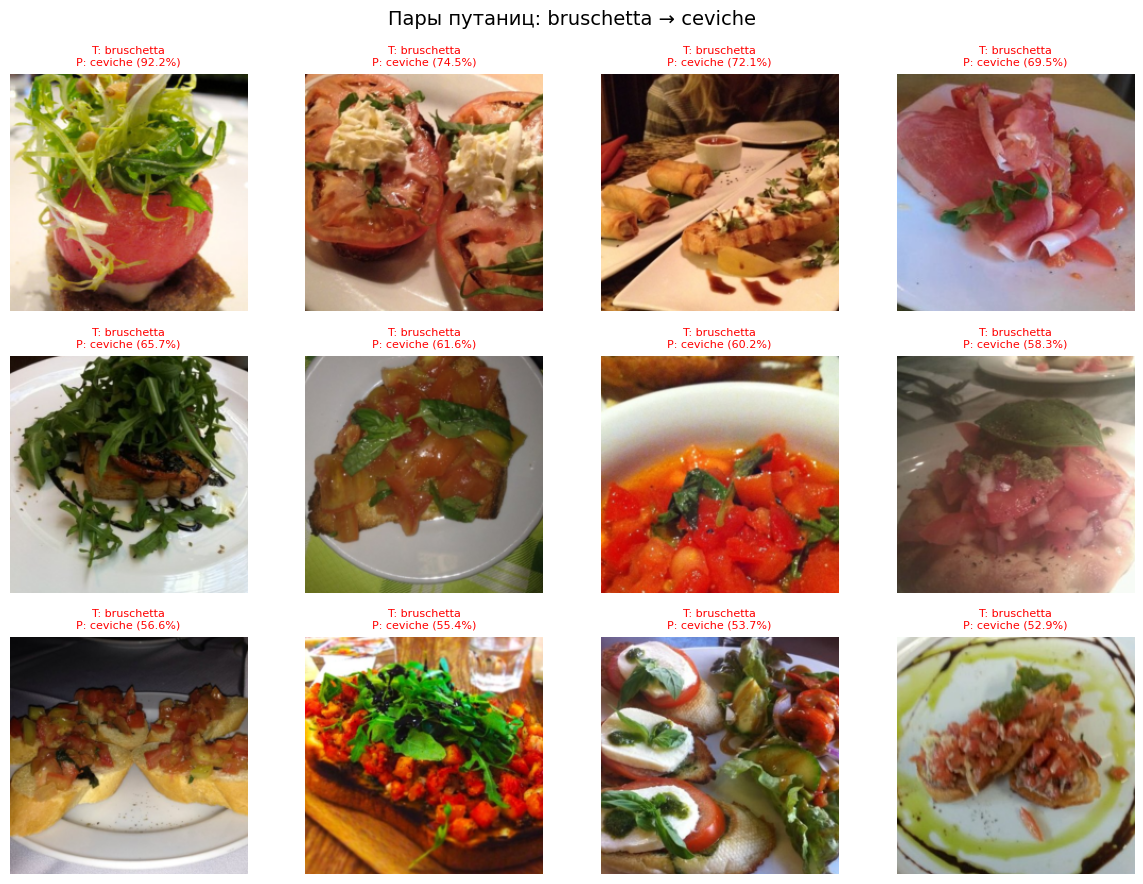

In [39]:
# ===== 5b.2. Most frequent confusion pair montage =====
# найдём пару (i->j) с макс. количеством ошибок
best_pair = None
best_cnt = -1
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > best_cnt:
            best_cnt = cm[i, j]; best_pair = (i, j)

print("Частейшая путаница:", class_names_small[best_pair[0]], "→", class_names_small[best_pair[1]], "|", int(best_cnt))

# отберём примеры именно этой путаницы
pair_samples = []
for img_t, true_y, pred_y, conf in wrong_samples:
    if true_y == best_pair[0] and pred_y == best_pair[1]:
        pair_samples.append((img_t, true_y, pred_y, conf))

K = min(12, len(pair_samples))
pair_samples = sorted(pair_samples, key=lambda x: x[3], reverse=True)[:K]

mean = torch.tensor(MEAN)[:, None, None]
std  = torch.tensor(STD)[:, None, None]

rows = int(np.ceil(K / 4))
fig, axs = plt.subplots(rows, 4, figsize=(12, 3*rows))
axs = np.array(axs).ravel()
for ax, (img_t, true_y, pred_y, conf) in zip(axs, pair_samples):
    img_show = (img_t * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
    ax.imshow(img_show)
    ax.set_title(f"T: {class_names_small[true_y]}\nP: {class_names_small[pred_y]} ({conf*100:.1f}%)",
                 fontsize=8, color="red")
    ax.axis("off")
for ax in axs[len(pair_samples):]:
    ax.remove()

plt.suptitle(f"Пары путаниц: {class_names_small[best_pair[0]]} → {class_names_small[best_pair[1]]}", y=0.98, fontsize=14)
plt.tight_layout(); plt.show()


Collect confidences:   0%|          | 0/59 [00:00<?, ?it/s]

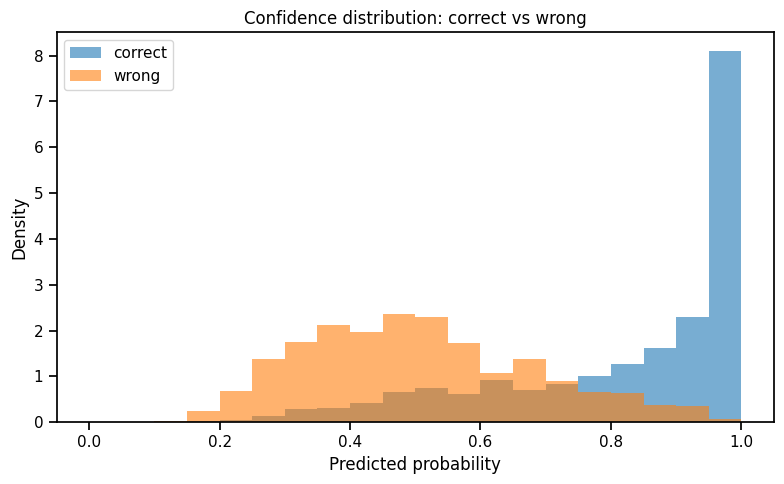

In [40]:
correct_confs, wrong_confs = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Collect confidences", leave=False):
        xb = xb.to(device); yb = yb.to(device)
        probs = torch.softmax(model(xb), dim=1)
        preds = probs.argmax(1)
        confs = probs[torch.arange(len(preds)), preds]

        correct_mask = (preds == yb)
        wrong_mask   = (preds != yb)

        correct_confs.extend(confs[correct_mask].cpu().tolist())
        wrong_confs.extend(confs[wrong_mask].cpu().tolist())

plt.figure(figsize=(8,5))
bins = np.linspace(0, 1, 21)
plt.hist(correct_confs, bins=bins, alpha=0.6, label="correct", density=True)
plt.hist(wrong_confs,   bins=bins, alpha=0.6, label="wrong",   density=True)
plt.xlabel("Predicted probability"); plt.ylabel("Density")
plt.title("Confidence distribution: correct vs wrong")
plt.legend(); plt.tight_layout(); plt.show()


Синие столбики справа (0.9–1.0) - большинство правильных ответов делается с высокой уверенностью.
Это нормальное и желаемое поведение — модель уверена, когда действительно права.

Оранжевая полоса в середине (0.3–0.6): большая часть ошибок приходится на умеренные уровни уверенности.
Модель «сомневается» и чаще ошибается в зонах неопределённости между классами.

Если бы оранжевая гистограмма была сильно сдвинута к 0.9–1.0, это означало бы переуверенность (overconfidence) — модель делает ошибки, но всё равно «уверена» в них на 95–100%.

In [47]:
# =============== Тот же процесс обучения, но с аугментациями (и сравнение с бейзлайном) ===============
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode

set_seed(42)

# --- 1) Трансформации: train с аугм., val/test как в бейзлайне ---
aug_train_tf = T.Compose([
    T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.20, contrast=0.20, saturation=0.20),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])
eval_tf = T.Compose([
    T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

# --- 2) Датасеты/лоадеры (те же параметры, что в бейзлайне; меняется только train_tf) ---
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_split, transform, label_map):
        self.data = hf_split
        self.tf = transform
        self.label_map = label_map
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        x = self.tf(ex["image"])
        y = self.label_map[int(ex["label"])]
        return x, y

train_ds_aug = HFDataset(food101_small["train"], aug_train_tf, LABEL2NEW)
val_ds_eval  = HFDataset(food101_small["val"],   eval_tf,     LABEL2NEW)
test_ds_eval = HFDataset(food101_small["test"],  eval_tf,     LABEL2NEW)

BATCH_SIZE = 64
train_loader_aug = DataLoader(train_ds_aug, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_eval  = DataLoader(val_ds_eval,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_eval = DataLoader(test_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Loaders: train_aug={len(train_ds_aug)}, val={len(val_ds_eval)}, test={len(test_ds_eval)}")

# --- 3) Реинициализация модели/оптимизатора (честное сравнение) ---
from torchvision import models

def build_baseline_model(num_classes: int):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in m.parameters(): p.requires_grad = False
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

model_aug = build_baseline_model(NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_aug.fc.parameters(), lr=1e-3)

# --- 4) Обучение только fc-головы (идентичный цикл; добавлен tqdm) ---
EPOCHS = 10
history_aug = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

def accuracy_from_logits(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

best_val_acc = -1.0
ckpt_aug_path = "best_model_aug_weak.pt"   # <- новый чекпоинт

for epoch in range(1, EPOCHS + 1):
    model_aug.train()
    tl, ta, n = 0.0, 0.0, 0
    for xb, yb in tqdm(train_loader_aug, desc=f"Epoch {epoch}/{EPOCHS} [train-aug]", leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model_aug(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        bs = yb.size(0); n += bs
        tl += loss.item() * bs
        ta += accuracy_from_logits(logits, yb) * bs
    tl /= n; ta /= n

    model_aug.eval()
    vl, va, n = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader_eval, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            logits = model_aug(xb)
            loss = criterion(logits, yb)
            bs = yb.size(0); n += bs
            vl += loss.item() * bs
            va += accuracy_from_logits(logits, yb) * bs
    vl /= n; va /= n

    history_aug["train_loss"].append(tl); history_aug["val_loss"].append(vl)
    history_aug["train_acc"].append(ta);  history_aug["val_acc"].append(va)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={tl:.4f} val_loss={vl:.4f} | "
          f"train_acc={ta*100:.1f}% val_acc={va*100:.1f}%")

    # сохраняем лучший по val_acc
    if va > best_val_acc:
        best_val_acc = va
        torch.save({
            "state_dict": model_aug.state_dict(),
            "num_classes": NUM_CLASSES,
            "chosen_cls": list(map(int, chosen_cls)),
            "label_map": LABEL2NEW,
            "meta": {"img_size": 224, "mean": MEAN, "std": STD, "aug": "weak"},
        }, ckpt_aug_path)
        print(f"💾 Saved best (aug-weak) → {ckpt_aug_path} @ val_acc={va*100:.2f}%")

print("✅ Обучение (aug) завершено.")


Loaders: train_aug=9000, val=2250, test=3750


Epoch 1/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/10 | train_loss=1.7467 val_loss=1.2314 | train_acc=51.0% val_acc=66.7%
💾 Saved best (aug-weak) → best_model_aug_weak.pt @ val_acc=66.67%


Epoch 2/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/10 | train_loss=1.1204 val_loss=1.0433 | train_acc=68.9% val_acc=69.1%
💾 Saved best (aug-weak) → best_model_aug_weak.pt @ val_acc=69.07%


Epoch 3/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/10 | train_loss=0.9763 val_loss=0.9703 | train_acc=71.2% val_acc=71.7%
💾 Saved best (aug-weak) → best_model_aug_weak.pt @ val_acc=71.73%


Epoch 4/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=0.8932 val_loss=0.9001 | train_acc=73.2% val_acc=73.2%
💾 Saved best (aug-weak) → best_model_aug_weak.pt @ val_acc=73.24%


Epoch 5/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/10 | train_loss=0.8645 val_loss=0.8914 | train_acc=73.7% val_acc=72.0%


Epoch 6/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/10 | train_loss=0.8363 val_loss=0.8724 | train_acc=74.4% val_acc=72.9%


Epoch 7/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/10 | train_loss=0.8066 val_loss=0.8527 | train_acc=75.4% val_acc=73.4%
💾 Saved best (aug-weak) → best_model_aug_weak.pt @ val_acc=73.42%


Epoch 8/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/10 | train_loss=0.7938 val_loss=0.8412 | train_acc=75.4% val_acc=75.1%
💾 Saved best (aug-weak) → best_model_aug_weak.pt @ val_acc=75.11%


Epoch 9/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 9/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/10 | train_loss=0.7695 val_loss=0.8545 | train_acc=76.3% val_acc=73.9%


Epoch 10/10 [train-aug]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 10/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.7719 val_loss=0.8353 | train_acc=76.2% val_acc=74.4%
✅ Обучение (aug) завершено.


[TEST] Baseline  Acc=77.20% | Macro-F1=0.774
[TEST] Aug-weak  Acc=78.00% | Macro-F1=0.779


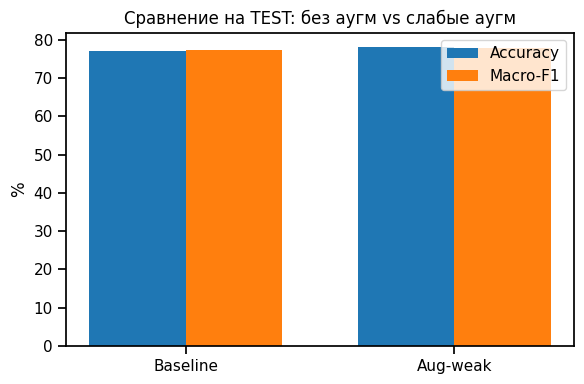

In [49]:
# --- Утилита: достать state_dict из разных форматов чекпоинтов ---
def extract_state_dict(ckpt: dict):
    if "state_dict" in ckpt:                # твой aug-чекпоинт
        return ckpt["state_dict"]
    if "model_state_dict" in ckpt:          # baseline, где сохраняли так
        return ckpt["model_state_dict"]
    # возможно, это уже чистый state_dict (ключи слоёв типа 'conv1.weight')
    # проверим по типам значений
    if isinstance(ckpt, dict) and any(k.endswith(".weight") or k.endswith(".bias") for k in ckpt.keys()):
        return ckpt
    raise KeyError("Не найден state_dict в чекпоинте")

# --- Сравнение с бейзлайном на одном и том же TEST-лоадере ---
base_ckpt_path = "best_model.pt"
assert os.path.exists(base_ckpt_path), "Не найден baseline чекпоинт best_model.pt"
base_ckpt = torch.load(base_ckpt_path, map_location=device)

model_base = build_baseline_model(NUM_CLASSES)
model_base.load_state_dict(extract_state_dict(base_ckpt), strict=True)
model_base = model_base.to(device).eval()

aug_ckpt = torch.load(ckpt_aug_path, map_location=device)
model_aug_best = build_baseline_model(NUM_CLASSES)
model_aug_best.load_state_dict(extract_state_dict(aug_ckpt), strict=True)
model_aug_best = model_aug_best.to(device).eval()

def eval_loader(model, loader):
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            ps.append(model(xb).argmax(1).cpu().numpy())
            ys.append(yb.cpu().numpy())
    y = np.concatenate(ys); p = np.concatenate(ps)
    return accuracy_score(y, p), f1_score(y, p, average="macro")

base_acc, base_f1 = eval_loader(model_base, test_loader_eval)
aug_acc,  aug_f1  = eval_loader(model_aug_best, test_loader_eval)

print(f"[TEST] Baseline  Acc={base_acc*100:.2f}% | Macro-F1={base_f1:.3f}")
print(f"[TEST] Aug-weak  Acc={aug_acc*100:.2f}% | Macro-F1={aug_f1:.3f}")

plt.figure(figsize=(6,4))
labels = ["Baseline", "Aug-weak"]
accs = [base_acc*100, aug_acc*100]
f1s  = [base_f1*100,  aug_f1*100]
x = np.arange(len(labels))
plt.bar(x-0.18, accs, width=0.36, label="Accuracy")
plt.bar(x+0.18, f1s,  width=0.36, label="Macro-F1")
plt.xticks(x, labels); plt.ylabel("%")
plt.title("Сравнение на TEST: без аугм vs слабые аугм")
plt.legend(); plt.tight_layout(); plt.show()


In [50]:
# =============== Блок 6b: Strong Aug + Регуляризация (и честное сравнение) ===============
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode

set_seed(42)

# --- 1) Трансформации: сильные для train; val/test как в бейзлайне ---
aug_strong_tf = T.Compose([
    T.RandomResizedCrop(224, scale=(0.6, 1.0), interpolation=InterpolationMode.BILINEAR),
    T.RandomHorizontalFlip(p=0.5),
    T.RandAugment(num_ops=2, magnitude=9),     # сильные цвет/геометрия (torchvision>=0.13)
    T.ToTensor(),
    T.Normalize(MEAN, STD),
    T.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value="random"),  # тензорный erasing
])

eval_tf = T.Compose([
    T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    T.ToTensor(),
    T.Normalize(MEAN, STD),
])

# --- 2) Датасеты/лоадеры (те же параметры, меняется только train_tf) ---
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_split, transform, label_map):
        self.data = hf_split
        self.tf = transform
        self.label_map = label_map
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[int(idx)]
        x = self.tf(ex["image"])
        y = self.label_map[int(ex["label"])]
        return x, y

train_ds_str = HFDataset(food101_small["train"], aug_strong_tf, LABEL2NEW)
val_ds_eval  = HFDataset(food101_small["val"],   eval_tf,     LABEL2NEW)
test_ds_eval = HFDataset(food101_small["test"],  eval_tf,     LABEL2NEW)

BATCH_SIZE = 64
train_loader_str = DataLoader(train_ds_str, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader_eval  = DataLoader(val_ds_eval,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_eval = DataLoader(test_ds_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Loaders: train_strong={len(train_ds_str)}, val={len(val_ds_eval)}, test={len(test_ds_eval)}")

# --- 3) Модель: тот же ResNet-18 с замороженным backbone, но голова с Dropout ---
from torchvision import models

def build_model_with_dropout(num_classes: int, p_drop: float = 0.2):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in m.parameters(): p.requires_grad = False
    in_f = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(p_drop),
        nn.Linear(in_f, num_classes)
    )
    return m.to(device)

model_str = build_model_with_dropout(NUM_CLASSES, p_drop=0.2)

# --- 4) Регуляризация в оптимизаторе и лоссах ---
# label smoothing снижает уверенность на обучении → меньше переобучение
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# weight decay как L2-регуляризация на весах
optimizer = torch.optim.AdamW(model_str.fc.parameters(), lr=1e-3, weight_decay=1e-4)

# --- 5) MixUp / CutMix на уровне батча (случайно) ---
import random

def rand_bbox(W, H, lam):
    # CutMix bbox
    cut_rat = (1 - lam) ** 0.5
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def apply_mixup_cutmix(x, y, alpha=0.4, p_mix=0.7):

    if random.random() > p_mix or alpha <= 0:
        return x, y, y, 1.0, "none", False
    lam = np.random.beta(alpha, alpha)
    indices = torch.randperm(x.size(0), device=x.device)
    y_b = y[indices]
    mode = "mixup" if random.random() < 0.5 else "cutmix"
    if mode == "mixup":
        x = lam * x + (1 - lam) * x[indices]
        y_a = y
    else:  # cutmix
        B, C, H, W = x.size()
        x1, y1, x2, y2 = rand_bbox(W, H, lam)
        x[:, :, y1:y2, x1:x2] = x[indices, :, y1:y2, x1:x2]
        # корректируем lam фактической площадью
        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
        y_a = y
    return x, y_a, y_b, lam, mode, True

def accuracy_from_logits(logits, targets):
    return (logits.argmax(1) == targets).float().mean().item()

EPOCHS = 10
history_str = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc = -1.0
ckpt_str_path = "best_model_aug_strong_reg.pt"   # новое имя чекпоинта

for epoch in range(1, EPOCHS + 1):
    # TRAIN (strong aug + mixup/cutmix)
    model_str.train()
    tl, ta, n = 0.0, 0.0, 0
    for xb, yb in tqdm(train_loader_str, desc=f"Epoch {epoch}/{EPOCHS} [train-strong]", leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        xb_mix, ya, yb2, lam, mode, used = apply_mixup_cutmix(xb, yb, alpha=0.4, p_mix=0.7)

        optimizer.zero_grad(set_to_none=True)
        logits = model_str(xb_mix)
        if used:
            loss = lam * criterion(logits, ya) + (1 - lam) * criterion(logits, yb2)
        else:
            loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        bs = yb.size(0); n += bs
        tl += loss.item() * bs
        # для acc считаем на «чистых» таргетах (оценка условная при mixup/cutmix)
        ta += accuracy_from_logits(logits, yb) * bs

    tl /= n; ta /= n

    # VAL (без аугм.)
    model_str.eval()
    vl, va, n = 0.0, 0.0, 0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader_eval, desc=f"Epoch {epoch}/{EPOCHS} [val]", leave=False):
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            logits = model_str(xb)
            loss = criterion(logits, yb)
            bs = yb.size(0); n += bs
            vl += loss.item() * bs
            va += accuracy_from_logits(logits, yb) * bs

    vl /= n; va /= n

    history_str["train_loss"].append(tl); history_str["val_loss"].append(vl)
    history_str["train_acc"].append(ta);  history_str["val_acc"].append(va)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={tl:.4f} val_loss={vl:.4f} | "
          f"train_acc={ta*100:.1f}% val_acc={va*100:.1f}%")

    if va > best_val_acc:
        best_val_acc = va
        torch.save({
            "state_dict": model_str.state_dict(),
            "num_classes": NUM_CLASSES,
            "chosen_cls": list(map(int, chosen_cls)),
            "label_map": LABEL2NEW,
            "meta": {"img_size": 224, "mean": MEAN, "std": STD,
                     "aug": "strong+mixup/cutmix", "dropout": 0.2,
                     "label_smoothing": 0.1, "wd": 1e-4},
        }, ckpt_str_path)
        print(f"💾 Saved best (strong+reg) → {ckpt_str_path} @ val_acc={va*100:.2f}%")

print("✅ Обучение (strong+reg) завершено.")


Loaders: train_strong=9000, val=2250, test=3750


Epoch 1/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 1/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 01/10 | train_loss=2.3668 val_loss=1.6970 | train_acc=24.3% val_acc=60.6%
💾 Saved best (strong+reg) → best_model_aug_strong_reg.pt @ val_acc=60.58%


Epoch 2/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 2/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 02/10 | train_loss=2.0353 val_loss=1.5424 | train_acc=38.8% val_acc=64.0%
💾 Saved best (strong+reg) → best_model_aug_strong_reg.pt @ val_acc=64.00%


Epoch 3/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 3/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 03/10 | train_loss=1.9962 val_loss=1.4315 | train_acc=37.8% val_acc=69.1%
💾 Saved best (strong+reg) → best_model_aug_strong_reg.pt @ val_acc=69.11%


Epoch 4/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 4/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 04/10 | train_loss=1.9028 val_loss=1.3819 | train_acc=44.3% val_acc=71.2%
💾 Saved best (strong+reg) → best_model_aug_strong_reg.pt @ val_acc=71.16%


Epoch 5/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 5/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 05/10 | train_loss=1.9061 val_loss=1.3872 | train_acc=44.1% val_acc=69.9%


Epoch 6/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 6/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 06/10 | train_loss=1.8898 val_loss=1.3772 | train_acc=45.7% val_acc=71.4%
💾 Saved best (strong+reg) → best_model_aug_strong_reg.pt @ val_acc=71.42%


Epoch 7/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 7/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 07/10 | train_loss=1.8804 val_loss=1.3386 | train_acc=47.0% val_acc=72.6%
💾 Saved best (strong+reg) → best_model_aug_strong_reg.pt @ val_acc=72.58%


Epoch 8/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 8/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 08/10 | train_loss=1.8604 val_loss=1.3563 | train_acc=45.2% val_acc=72.1%


Epoch 9/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 9/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 09/10 | train_loss=1.8679 val_loss=1.3440 | train_acc=45.3% val_acc=72.4%


Epoch 10/10 [train-strong]:   0%|          | 0/141 [00:00<?, ?it/s]

Epoch 10/10 [val]:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=1.8742 val_loss=1.3759 | train_acc=42.3% val_acc=70.2%
✅ Обучение (strong+reg) завершено.


[TEST] Baseline         Acc=77.20% | Macro-F1=77.39%
[TEST] Aug-weak         Acc=78.00% | Macro-F1=77.88%
[TEST] Aug-strong+Reg    Acc=76.67% | Macro-F1=76.53%


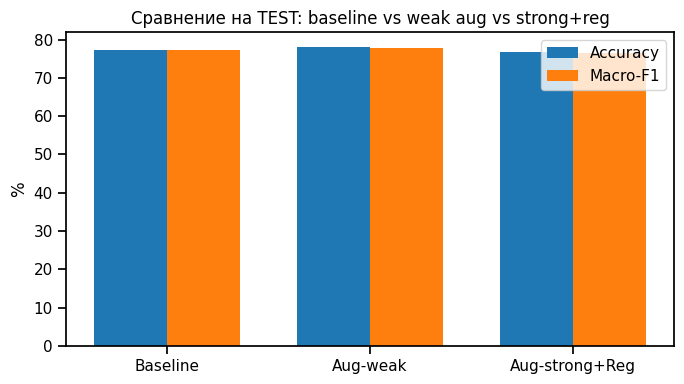

In [51]:
# --- 7) Сравнение на одном и том же TEST-лоадере: baseline vs aug-weak vs aug-strong+reg ---

from torchvision import models

def build_baseline_model(num_classes: int):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in m.parameters(): p.requires_grad = False
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)

def extract_state_dict(ckpt: dict):
    if isinstance(ckpt, dict):
        if "state_dict" in ckpt:
            return ckpt["state_dict"]
        if "model_state_dict" in ckpt:
            return ckpt["model_state_dict"]
        # возможно, это уже чистый state_dict
        if any(isinstance(v, torch.Tensor) for v in ckpt.values()) and \
           any(k.endswith(".weight") or k.endswith(".bias") for k in ckpt.keys()):
            return ckpt
    raise KeyError("Не найден state_dict в чекпоинте")

def safe_load_model(path: str, build_fn, num_classes: int):
    assert os.path.exists(path), f"Чекпоинт не найден: {path}"
    ckpt = torch.load(path, map_location=device)
    # если в ckpt сохранён num_classes — проверим
    if isinstance(ckpt, dict) and "num_classes" in ckpt:
        if ckpt["num_classes"] != num_classes:
            raise ValueError(f"num_classes в ckpt={ckpt['num_classes']} != текущему={num_classes}")
    model = build_fn(num_classes)
    sd = extract_state_dict(ckpt)
    model.load_state_dict(sd, strict=True)
    return model.to(device).eval()

def eval_loader(model, loader):
    ys, ps = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            ps.append(model(xb).argmax(1).cpu().numpy())
            ys.append(yb.cpu().numpy())
    y = np.concatenate(ys); p = np.concatenate(ps)
    return accuracy_score(y, p), f1_score(y, p, average="macro")

# (a) baseline
model_base = safe_load_model("best_model.pt", build_baseline_model, NUM_CLASSES)
base_acc, base_f1 = eval_loader(model_base, test_loader_eval)

# (b) aug-weak (если есть)
augw_acc = augw_f1 = None
if os.path.exists("best_model_aug_weak.pt"):
    model_augw = safe_load_model("best_model_aug_weak.pt", build_baseline_model, NUM_CLASSES)
    augw_acc, augw_f1 = eval_loader(model_augw, test_loader_eval)

# (c) aug-strong+reg
model_str_best = safe_load_model(ckpt_str_path, lambda nc: build_model_with_dropout(nc, p_drop=0.2), NUM_CLASSES)
str_acc, str_f1 = eval_loader(model_str_best, test_loader_eval)

print(f"[TEST] Baseline         Acc={base_acc*100:.2f}% | Macro-F1={base_f1*100:.2f}%")
if augw_acc is not None:
    print(f"[TEST] Aug-weak         Acc={augw_acc*100:.2f}% | Macro-F1={augw_f1*100:.2f}%")
print(f"[TEST] Aug-strong+Reg    Acc={str_acc*100:.2f}% | Macro-F1={str_f1*100:.2f}%")

labels = ["Baseline"]
accs   = [base_acc*100]
f1s    = [base_f1*100]
if augw_acc is not None:
    labels.append("Aug-weak"); accs.append(augw_acc*100); f1s.append(augw_f1*100)
labels.append("Aug-strong+Reg"); accs.append(str_acc*100); f1s.append(str_f1*100)

x = np.arange(len(labels))
plt.figure(figsize=(7,4))
plt.bar(x-0.18, accs, width=0.36, label="Accuracy")
plt.bar(x+0.18, f1s,  width=0.36, label="Macro-F1")
plt.xticks(x, labels); plt.ylabel("%")
plt.title("Сравнение на TEST: baseline vs weak aug vs strong+reg")
plt.legend(); plt.tight_layout(); plt.show()


In [52]:
import numpy as np, torch
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc

def collect_preds_probs(model, loader):
    ys, ps, pr = [], [], []  # y_true, y_pred, probs (N x C)
    model.eval()
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Collect", leave=False):
            xb = xb.to(device); yb = yb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            pr.append(probs.cpu().numpy())
            ps.append(logits.argmax(1).cpu().numpy())
            ys.append(yb.cpu().numpy())
    y = np.concatenate(ys)
    p = np.concatenate(ps)
    prob = np.concatenate(pr, axis=0)
    return y, p, prob

y_b, p_b, prob_b = collect_preds_probs(model_base,      test_loader_eval)
y_s, p_s, prob_s = collect_preds_probs(model_str_best,  test_loader_eval)
if 'model_augw' in globals() and model_augw is not None:
    y_w, p_w, prob_w = collect_preds_probs(model_augw,  test_loader_eval)
else:
    y_w = p_w = prob_w = None


Collect:   0%|          | 0/59 [00:00<?, ?it/s]

Collect:   0%|          | 0/59 [00:00<?, ?it/s]

Collect:   0%|          | 0/59 [00:00<?, ?it/s]

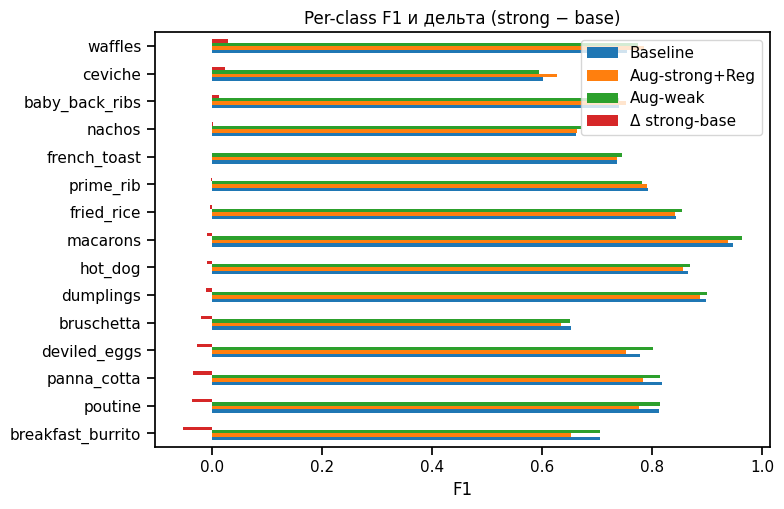

In [53]:
import pandas as pd
from sklearn.metrics import classification_report

def per_class_f1(y, p):
    rep = classification_report(y, p, target_names=class_names_small, output_dict=True, zero_division=0)
    return pd.Series({c: rep[c]["f1-score"] for c in class_names_small})

f1_base = per_class_f1(y_b, p_b)
f1_str  = per_class_f1(y_s, p_s)
df = pd.DataFrame({"Baseline": f1_base, "Aug-strong+Reg": f1_str})
if y_w is not None:
    df["Aug-weak"] = per_class_f1(y_w, p_w)

df["Δ strong-base"] = df["Aug-strong+Reg"] - df["Baseline"]
df.sort_values("Δ strong-base", ascending=True).plot.barh(figsize=(8, max(4, 0.35*len(df))))
plt.title("Per-class F1 и дельта (strong − base)")
plt.xlabel("F1")
plt.tight_layout(); plt.show()


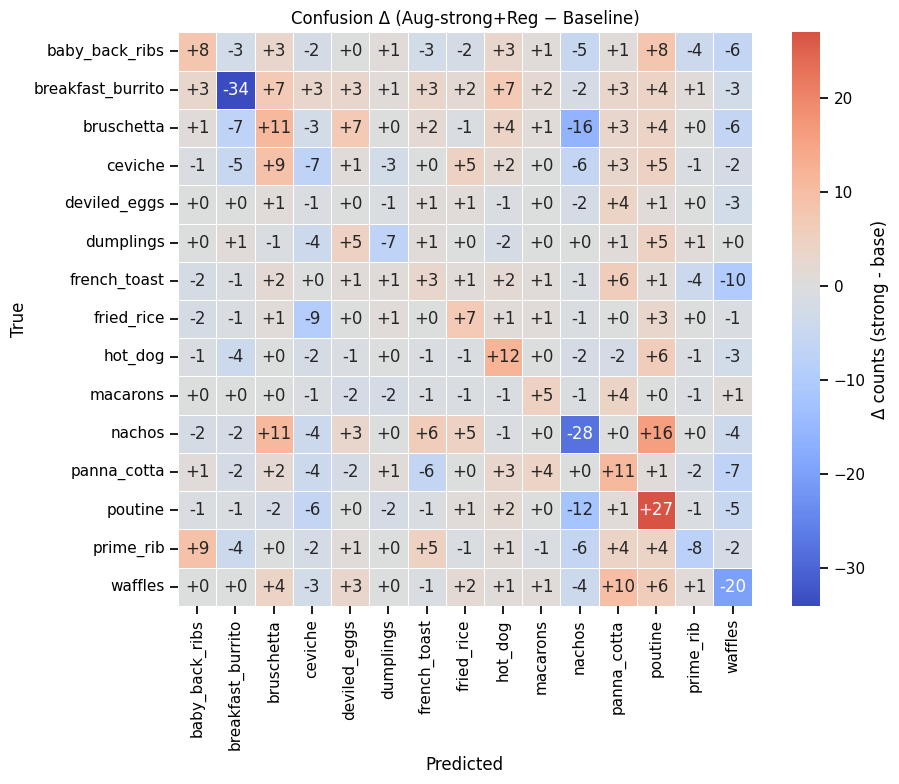

In [54]:
cm_base = confusion_matrix(y_b, p_b, labels=list(range(NUM_CLASSES)))
cm_str  = confusion_matrix(y_s, p_s, labels=list(range(NUM_CLASSES)))
cm_diff = cm_str - cm_base  # >0 значит strong чаще предсказывал этот (true->pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm_diff, annot=True, fmt="+d", cmap="coolwarm", center=0,
            xticklabels=class_names_small, yticklabels=class_names_small,
            cbar_kws={"label": "Δ counts (strong - base)"}, linewidths=0.5, linecolor="white", square=True)
plt.title("Confusion Δ (Aug-strong+Reg − Baseline)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


ECE (↓ лучше): Baseline 0.0303 | Strong 0.209 | Weak 0.0501


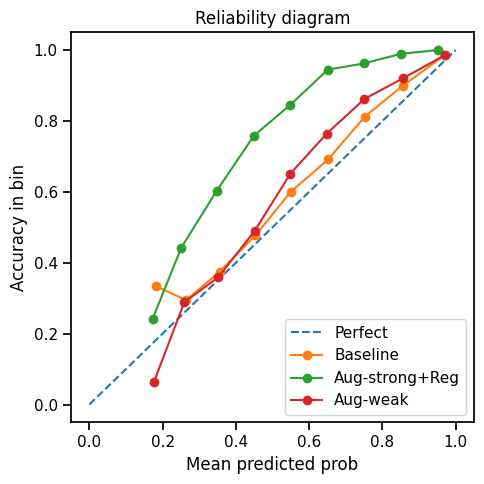

In [55]:
def expected_calibration_error(y_true, prob, n_bins=15):
    p = prob.max(axis=1)
    y_pred = prob.argmax(1)
    correct = (y_pred == y_true).astype(int)
    bins = np.linspace(0,1,n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (p >= lo) & (p < hi) if i < n_bins-1 else (p >= lo) & (p <= hi)
        if mask.sum() == 0: continue
        conf_bin = p[mask].mean()
        acc_bin  = correct[mask].mean()
        ece += (mask.mean()) * abs(acc_bin - conf_bin)
    return ece

ece_b = expected_calibration_error(y_b, prob_b)
ece_s = expected_calibration_error(y_s, prob_s)
ece_w = expected_calibration_error(y_w, prob_w) if y_w is not None else None
print("ECE (↓ лучше): Baseline", round(ece_b,4), "| Strong", round(ece_s,4), "| Weak", None if ece_w is None else round(ece_w,4))

# Reliability diagram (3 модели на одном графике)
def reliability_points(y_true, prob, n_bins=10):
    p = prob.max(axis=1)
    y_pred = prob.argmax(1)
    correct = (y_pred == y_true).astype(int)
    bins = np.linspace(0,1,n_bins+1)
    xs, ys = [], []
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (p >= lo) & (p < hi) if i < n_bins-1 else (p >= lo) & (p <= hi)
        if mask.sum() == 0: continue
        xs.append(p[mask].mean())
        ys.append(correct[mask].mean())
    return np.array(xs), np.array(ys)

xb, yb_ = reliability_points(y_b, prob_b)
xs, ys_ = reliability_points(y_s, prob_s)
if y_w is not None:
    xw, yw_ = reliability_points(y_w, prob_w)

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'--',label="Perfect")
plt.plot(xb, yb_, marker='o', label="Baseline")
plt.plot(xs, ys_, marker='o', label="Aug-strong+Reg")
if y_w is not None:
    plt.plot(xw, yw_, marker='o', label="Aug-weak")
plt.xlabel("Mean predicted prob"); plt.ylabel("Accuracy in bin")
plt.title("Reliability diagram")
plt.legend(); plt.tight_layout(); plt.show()


In [57]:
def topk_acc(prob, y_true, k):
    topk = np.argpartition(-prob, kth=k-1, axis=1)[:, :k]
    hits = np.any(topk == y_true[:,None], axis=1)
    return hits.mean()

for k in [1,3,5]:
    print(f"Top-{k} Acc | Base: {topk_acc(prob_b, y_b, k):.3f} | Strong: {topk_acc(prob_s, y_s, k):.3f} | Weak:", 
          "n/a" if prob_w is None else f"{topk_acc(prob_w, y_w, k):.3f}")


Top-1 Acc | Base: 0.772 | Strong: 0.767 | Weak: 0.780
Top-3 Acc | Base: 0.928 | Strong: 0.926 | Weak: 0.933
Top-5 Acc | Base: 0.966 | Strong: 0.966 | Weak: 0.968


## Анализ Top-K Accuracy

| Модель | Top-1 | Top-3 | Top-5 |
|:--|:--:|:--:|:--:|
| **Baseline** | 0.772 | 0.928 | 0.966 |
| **Aug-weak** | **0.780** | **0.933** | **0.968** |
| **Aug-strong + Reg** | 0.767 | 0.926 | 0.966 |

---

### 📈 Интерпретация
- **Top-1 (точность первой гипотезы)**  
  Слабые аугментации немного улучшили точность (+0.8 pp), а сильные + регуляризация — слегка понизили (-0.5 pp).  
  👉 Лёгкие искажения делают модель устойчивее к шуму, тогда как агрессивные аугм. и dropout немного снижают решительность.

- **Top-3**  
  Почти одинаковые значения ≈ 0.93, причём *Aug-weak* лидирует.  
  👉 Модель почти всегда помещает правильный класс хотя бы в тройку наиболее вероятных — она «знает ответ», но не всегда выбирает его первой.

- **Top-5**  
  Все модели достигают ≈ 0.97 — правильный класс попадает в пятёрку лучших в 96–97 % случаев.  
  👉 Ошибки происходят в основном между близкими классами; ранжирование вероятностей стабильное.

---

### 💡 Вывод
> Аугментации не ухудшили способность модели различать классы.  
> **Aug-weak** показал лучший баланс между устойчивостью и точностью.  
> **Aug-strong + Reg** немного осторожнее (чуть ниже Top-1), но сохраняет правильное ранжирование и уверенность в топ-предсказаниях.
